# 4C: Computing Clusters of Correlation Connected Objects

1650
2


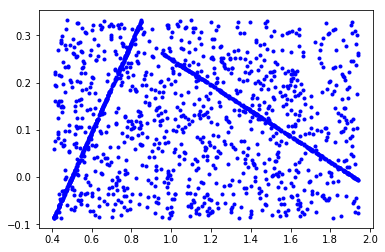

In [1]:
__author__ = 'schubert'

import sys
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh

#reading csv Data into a File
def read_data(file):
    f = open( file, 'r')
    data = []
    for line in f:
        line = line.split(';')
        del line[-1]
        vec = np.zeros(len(line))
        c = 0
        for x in line:
            vec[c] = x
            c += 1
        data.append(vec)
    f.close()
    return data

#read data
D = read_data('data.csv')
#set dimensionality d and number of instances n
d = np.shape(D[0])[0]
n = len(D)
print(n)
print(d)

xs =[x[0] for x in D]
ys =[x[1] for x in D]

plt.plot(xs,ys,'b.')
plt.show()

Write an eps Range Query to determine the local environment of X.
Input: Dataset D, query vector q and range epsilon
Output: A numpy matrix where each row is a neigboring feature vector.

In [2]:
def eps_range(q, D, epsilon):
    eps_sqr =epsilon*epsilon
    result = []
    for x in D:
        diff = x-q
        dist = np.dot(diff,diff.T)
        if dist < eps_sqr:
            result.append(x)
    return np.asarray(result)

Determine the local correlations for all data objects and store them in a list.
Input: Dataset D, range epsilon, weight of low variant dimensions kappa, and decision threshold delta
Output: A list containing all local correlation distance matrices

In [3]:
def derive_local_correlations(D,epsilon, kappa, delta):
    dist_mat = []
    counter = 0;
    for q in D:
        #print counter
        S = eps_range(q, D , epsilon)
        d_S = np.shape(S)[1]
        S =S-S.mean(axis=0)
        n_S = np.shape(S)[0]
        cov_S = (1/float(n_S))* np.dot(S.T,S)
        evs, evmat = eigh(cov_S)
        s=np.zeros(d_S)
        evs = evs/evs.sum()
        for i in range(0,d_S):
            if evs[i] < delta:
                s[i] = kappa
            else:
                s[i] = 1
        s = np.diag(s)
        C = np.dot(evmat,np.dot(s,evmat.T))
        dist_mat.append( C)
        counter +=1
    return dist_mat


Write a function for computing the correlation distance between x having local distance S1 and y having local distance S2.

In [4]:
def correlation_dist(x,S1, y,S2):
    diff = x-y
    if S1 == None or S2 == None:
        return sys.float_info.max
    d1 = np.dot(np.dot(diff, S1),diff.T)
    d2 = np.dot(np.dot(diff, S2),diff.T)
    return max(d1,d2)

Compute an eps-range query on D using the local correlation distance.
Note: The query is given as the row index in D to make finding its local correlation distance in the list mats easier.

In [5]:
def corr_eps_range(query_id, D, epsilon, mats):
    eps_sqr =epsilon*epsilon
    result = []
    local_c = 0
    q = D[query_id]
    S1 = mats[query_id]
    for x in D:
        S2= mats[local_c]
        dist = correlation_dist(q,S1,x,S2)
        if dist <eps_sqr:
            result.append(local_c)
        local_c +=1
    return result

Implement 4C based on the given functions:

In [6]:
def algorithm4c(eps, minpts,kappa, delta):
    global processed, cur_cluster_ID
    # build local distance measures
    cor_mat = derive_local_correlations(D, eps, kappa, delta)
    print('Finished preprocessing')
    # run 4C
    processed = np.zeros(n)
    cur_cluster_ID = 1
    for outer in range(0, n):
        if processed[outer] == 0:
            if expand(outer, D, eps, minpts, cur_cluster_ID, cor_mat, processed):
                print ('Found cluster %s' % cur_cluster_ID)
                cur_cluster_ID += 1
            else:
                processed[outer] = -1
    return processed


def expand(outer,D,eps, minPts, cur_cluster_ID,mats,processed):
    seed = corr_eps_range(outer,D,eps, mats)
    #return if no core point
    if len(seed) < minPts:
        return False
    #outer is core point
    processed[outer] = cur_cluster_ID
    while seed:
        q = seed.pop()
        if processed[q] == 0:
            range = corr_eps_range(q,D,eps,mats)
            if len(range) >= minPts:
                for x in range:
                    seed.append(x)
        processed[q] = cur_cluster_ID
    return True

Run 4C on D and plot the found clusteris.

Finished preprocessing


/home/lu/data/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()


Found cluster 1
Found cluster 2
Found cluster 3
Found cluster 4
Found cluster 5
Found cluster 6
Found cluster 7


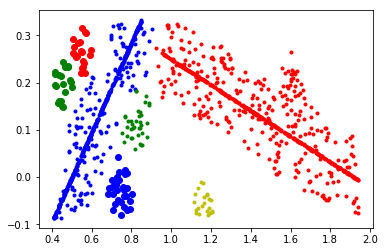

In [7]:
#set of local parameters
minpts = 20
eps = 0.05
kappa = 50
delta = 0.1

cluster_IDs = algorithm4c(eps, minpts,kappa, delta)
#plot clusters
cluster_design = ['r.','b.','g.','y.','ro','bo','go','yo','r+','b+','g+','y+','r-','b-','g-','y-']
for c in range(1,cur_cluster_ID):
    x=[]
    y=[]
    for i in range(0,n):
       if c == processed[i]:
           x.append(D[i][0])
           y.append(D[i][1])
    plt.plot(x,y,cluster_design[(c-1)%len(cluster_design)])
plt.show()
